# CICIDS2017 Exploratory Data Analysis

**Pure exploration only** - no model training, no saved artifacts.

This notebook explores the CICIDS2017 dataset structure, distributions, and quality issues to inform preprocessing decisions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Display settings
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load data with relative paths
PROJECT_ROOT = Path().cwd().parent
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "cicids_10pct_stratified.csv"

print(f"Loading data from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")

Loading data from: d:\Coding\VanetUAV\data\processed\cicids_10pct_stratified.csv
Dataset shape: (283074, 84)


## 1. Dataset Overview

In [3]:
# Basic dataset info
print("Columns:", df.columns.tolist()[:10], "...")  # First 10 columns
print(f"\nData types:")
print(df.dtypes.value_counts())
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Columns: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std'] ...

Data types:
int64      56
float64    24
str         4
Name: count, dtype: int64

Memory usage: 242.1 MB


## 2. Target Variable Analysis

In [4]:
# Attack type distribution
print("Label distribution:")
label_counts = df['Label'].value_counts()
print(label_counts)

# Binary target
df['target'] = (df['Label'] != 'BENIGN').astype(int)
print(f"\nBinary attack rate: {df['target'].mean():.3f}")

Label distribution:
Label
BENIGN                        227309
DoS Hulk                       23068
PortScan                       15952
DDoS                           12760
DoS GoldenEye                   1032
FTP-Patator                      762
SSH-Patator                      619
DoS Slowhttptest                 585
DoS slowloris                    574
Bot                              210
Web Attack � Brute Force         138
Web Attack � XSS                  58
Infiltration                       4
Web Attack � Sql Injection         3
Name: count, dtype: int64

Binary attack rate: 0.197


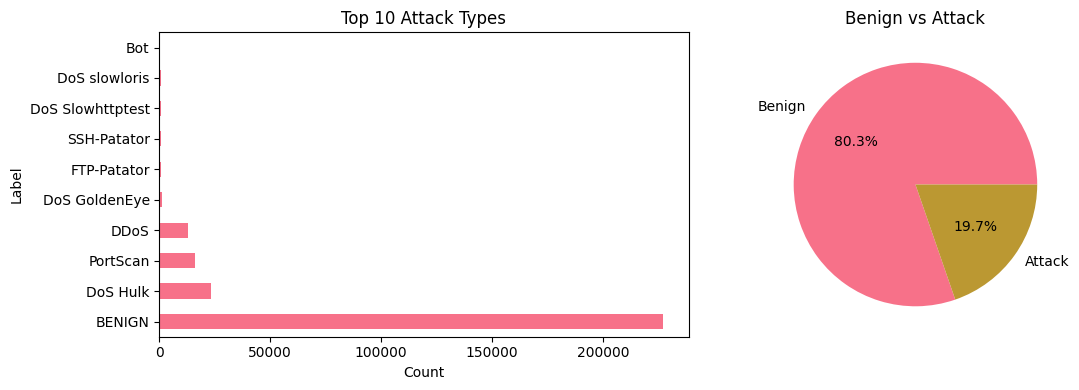

In [5]:
# Visualize attack distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Attack types
label_counts.head(10).plot(kind='barh', ax=ax1)
ax1.set_title('Top 10 Attack Types')
ax1.set_xlabel('Count')

# Binary distribution
df['target'].value_counts().plot(kind='pie', ax=ax2, labels=['Benign', 'Attack'], autopct='%1.1f%%')
ax2.set_title('Benign vs Attack')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## 3. Temporal Distribution (by File/Day)

In [6]:
# Attack rate by source file
file_stats = df.groupby('source_file').agg({
    'target': ['count', 'mean'],
    'Label': lambda x: x.value_counts().index[0]  # Most common attack type
}).round(3)

file_stats.columns = ['sample_count', 'attack_rate', 'primary_attack_type']
file_stats = file_stats.sort_values('attack_rate')

print("Attack rate by file:")
print(file_stats)

Attack rate by file:
                                                    sample_count  attack_rate  \
source_file                                                                     
Monday-WorkingHours.pcap_ISCX.csv                          53165        0.000   
Thursday-WorkingHours-Afternoon-Infilteration.p...         29005        0.000   
Friday-WorkingHours-Morning.pcap_ISCX.csv                  19082        0.011   
Thursday-WorkingHours-Morning-WebAttacks.pcap_I...         16905        0.012   
Tuesday-WorkingHours.pcap_ISCX.csv                         44778        0.031   
Wednesday-workingHours.pcap_ISCX.csv                       69030        0.366   
Friday-WorkingHours-Afternoon-PortScan.pcap_ISC...         28650        0.557   
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv           22459        0.568   

                                                   primary_attack_type  
source_file                                                             
Monday-WorkingHours.pc

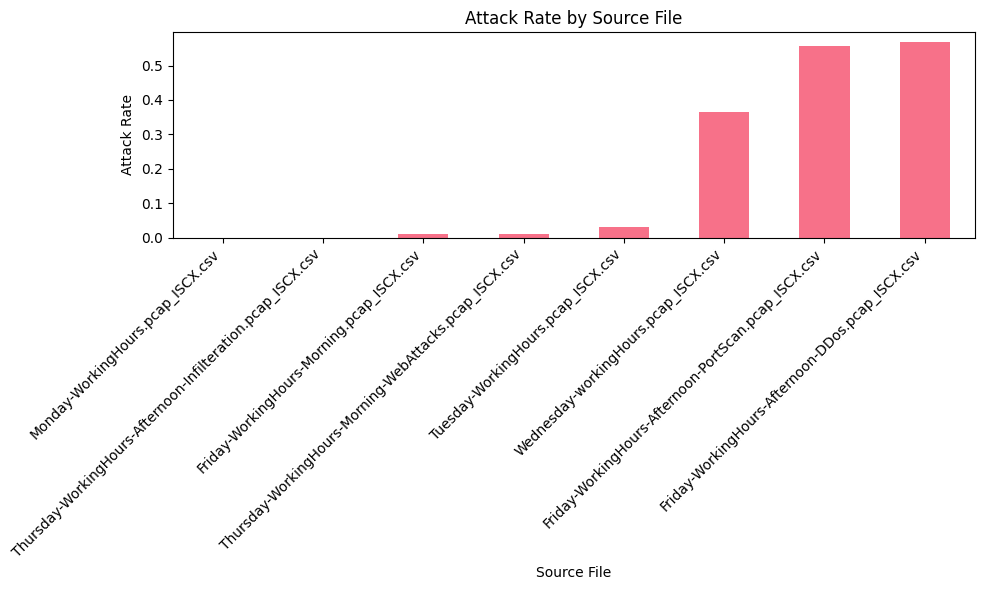

In [7]:
# Visualize attack rates by day
plt.figure(figsize=(10, 6))
file_stats['attack_rate'].plot(kind='bar')
plt.title('Attack Rate by Source File')
plt.xlabel('Source File')
plt.ylabel('Attack Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Feature Quality Assessment

In [8]:
# Get numeric features only
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove metadata columns
numeric_features = [col for col in numeric_features if col not in ['target', 'label_bin']]

print(f"Numeric features: {len(numeric_features)}")

# Check for inf/nan issues
X_numeric = df[numeric_features]
nan_counts = X_numeric.isna().sum()
inf_counts = np.isinf(X_numeric).sum()

print(f"\nColumns with NaN: {(nan_counts > 0).sum()}")
print(f"Columns with Inf: {(inf_counts > 0).sum()}")

Numeric features: 79

Columns with NaN: 1
Columns with Inf: 2


In [9]:
# Show worst quality features
quality_issues = pd.DataFrame({
    'nan_count': nan_counts,
    'inf_count': inf_counts,
    'nan_rate': nan_counts / len(df),
    'inf_rate': inf_counts / len(df)
})

quality_issues['total_bad_rate'] = quality_issues['nan_rate'] + quality_issues['inf_rate']
worst_features = quality_issues[quality_issues['total_bad_rate'] > 0.01].sort_values('total_bad_rate', ascending=False)

if len(worst_features) > 0:
    print("Features with >1% nan/inf:")
    print(worst_features.head(10))
else:
    print("✅ No major quality issues found")

✅ No major quality issues found


## 5. Feature Distribution Patterns

C:\Users\vpahu\AppData\Local\Temp\ipykernel_46684\2457341204.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  if data.max() / data.min() > 1000:


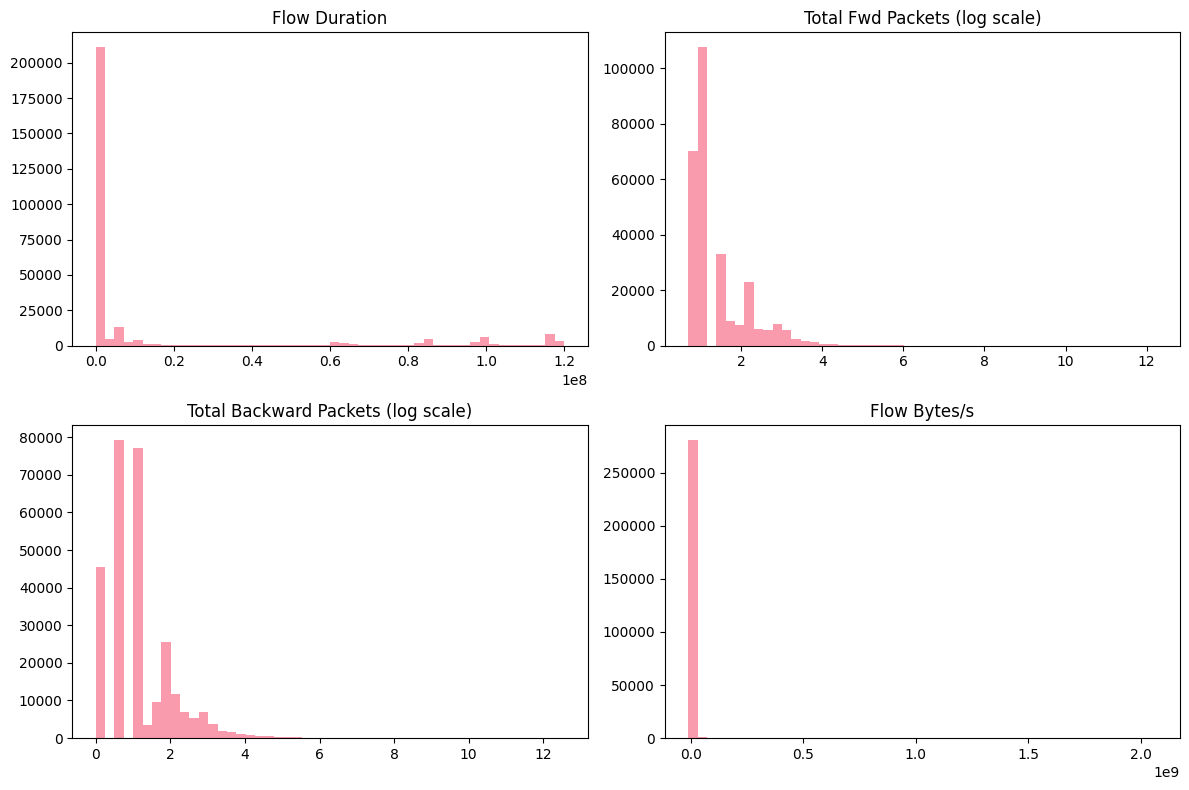

In [10]:
# Sample a few key features for distribution analysis
sample_features = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packet Length Mean'
]

# Only use features that exist
sample_features = [f for f in sample_features if f in numeric_features]

if len(sample_features) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, feature in enumerate(sample_features[:4]):
        # Remove inf/nan for plotting
        data = df[feature].replace([np.inf, -np.inf], np.nan).dropna()
        if len(data) > 0:
            # Use log scale if data spans multiple orders of magnitude
            if data.max() / data.min() > 1000:
                data = np.log1p(data)  # log(1+x) to handle zeros
                axes[i].hist(data, bins=50, alpha=0.7)
                axes[i].set_title(f'{feature} (log scale)')
            else:
                axes[i].hist(data, bins=50, alpha=0.7)
                axes[i].set_title(feature)
    
    plt.tight_layout()
    plt.show()
else:
    print("Sample features not found, skipping distribution plots")

## 6. Feature Correlation with Target

d:\Coding\VanetUAV\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\Coding\VanetUAV\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top 15 features by correlation with attack:
label_binary              1.000
Bwd Packet Length Std     0.508
Bwd Packet Length Max     0.490
Bwd Packet Length Mean    0.482
Avg Bwd Segment Size      0.482
Packet Length Std         0.468
Max Packet Length         0.453
Packet Length Variance    0.451
Fwd IAT Std               0.424
Packet Length Mean        0.412
Average Packet Size       0.411
Idle Max                  0.395
Idle Mean                 0.391
Fwd IAT Max               0.390
Flow IAT Max              0.389
dtype: float64


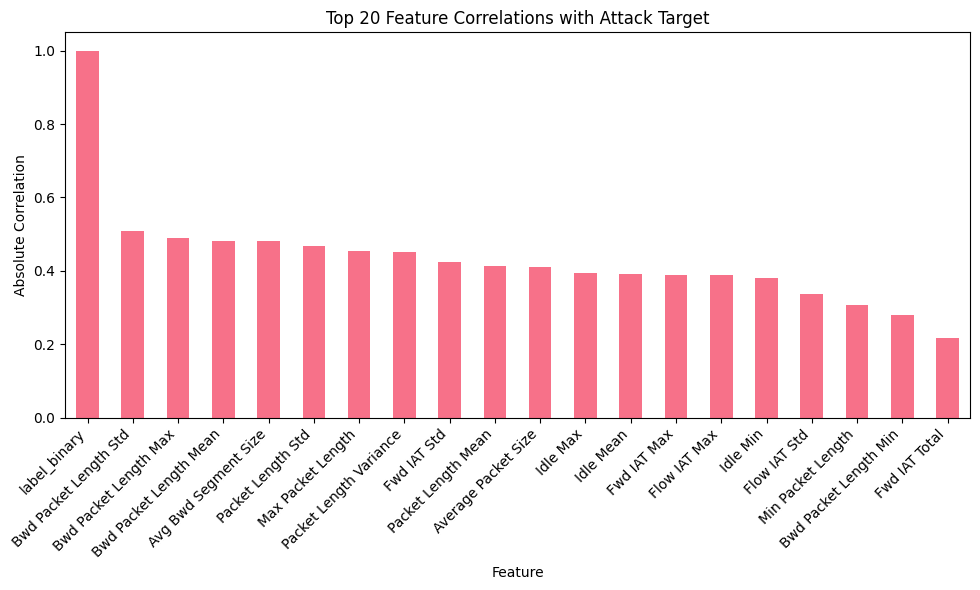

In [11]:
# Calculate correlation with target (handle inf/nan)
X_clean = X_numeric.replace([np.inf, -np.inf], np.nan).fillna(0)
correlations = X_clean.corrwith(df['target']).abs().sort_values(ascending=False)

print("Top 15 features by correlation with attack:")
print(correlations.head(15).round(3))

# Plot top correlations
plt.figure(figsize=(10, 6))
correlations.head(20).plot(kind='bar')
plt.title('Top 20 Feature Correlations with Attack Target')
plt.xlabel('Feature')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Summary

**Key Findings:**

1. **Class Imbalance:** Significant imbalance between benign and attack traffic
2. **Temporal Patterns:** Attack rates vary significantly by day/file  
3. **Data Quality:** Some features have inf/nan values requiring preprocessing
4. **Feature Relevance:** Clear correlation patterns between features and attack labels

**Preprocessing Recommendations:**
- Handle inf/nan values with imputation
- Apply standard scaling due to varying feature ranges 
- Consider PCA for dimensionality reduction
- Use temporal split (train on Mon-Thu, test on Fri) to avoid leakage

**Next Step:** Proceed to `02_modelling_centralized.ipynb` for leakage-safe modeling.

In [12]:
import pandas as pd
import os

DATA_DIR = "../data/raw/MachineLearningCVE"

files = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
len(files), files[:8]

(8,
 ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
  'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
  'Friday-WorkingHours-Morning.pcap_ISCX.csv',
  'Monday-WorkingHours.pcap_ISCX.csv',
  'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
  'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
  'Tuesday-WorkingHours.pcap_ISCX.csv',
  'Wednesday-workingHours.pcap_ISCX.csv'])

In [13]:
sample_file = files[1]
df = pd.read_csv(os.path.join(DATA_DIR, sample_file))

df.shape, df.columns.tolist()

((286467, 79),
 [' Destination Port',
  ' Flow Duration',
  ' Total Fwd Packets',
  ' Total Backward Packets',
  'Total Length of Fwd Packets',
  ' Total Length of Bwd Packets',
  ' Fwd Packet Length Max',
  ' Fwd Packet Length Min',
  ' Fwd Packet Length Mean',
  ' Fwd Packet Length Std',
  'Bwd Packet Length Max',
  ' Bwd Packet Length Min',
  ' Bwd Packet Length Mean',
  ' Bwd Packet Length Std',
  'Flow Bytes/s',
  ' Flow Packets/s',
  ' Flow IAT Mean',
  ' Flow IAT Std',
  ' Flow IAT Max',
  ' Flow IAT Min',
  'Fwd IAT Total',
  ' Fwd IAT Mean',
  ' Fwd IAT Std',
  ' Fwd IAT Max',
  ' Fwd IAT Min',
  'Bwd IAT Total',
  ' Bwd IAT Mean',
  ' Bwd IAT Std',
  ' Bwd IAT Max',
  ' Bwd IAT Min',
  'Fwd PSH Flags',
  ' Bwd PSH Flags',
  ' Fwd URG Flags',
  ' Bwd URG Flags',
  ' Fwd Header Length',
  ' Bwd Header Length',
  'Fwd Packets/s',
  ' Bwd Packets/s',
  ' Min Packet Length',
  ' Max Packet Length',
  ' Packet Length Mean',
  ' Packet Length Std',
  ' Packet Length Variance',
  'FI

In [14]:
def clean_columns(df):
    # remove leading/trailing spaces
    df.columns = [c.strip() for c in df.columns]
    return df

df = clean_columns(df)
df.columns.tolist()

['Destination Port',
 'Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Length',
 'Bwd Header Length',
 'Fwd Packets/s',
 'Bwd Packets/s',
 'Min Packet Length',
 'Max Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'UR